In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


No projector specified for this dataset. Please consider the method self.add_proj.


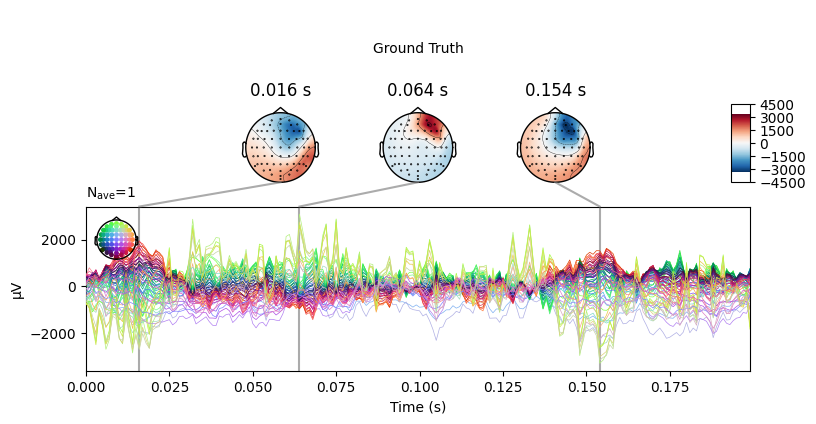

In [4]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=10,
    n_orders=2,
    snr_range=(1e99, 2e99),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

In [9]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout
# from multihead_attention import MultiHeadAttention
# from positional_encoding import PositionEmbeddingFixedWeights
 
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices
# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
 
    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
 
        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask
 
        # Computing the weights by a softmax operation
        weights = softmax(scores)
 
        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)
 
# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output
 
    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x
 
    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
 
        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
 
        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
 
        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
 
        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)
 
        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer
 
    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x
 
        # Apply layer normalization to the sum
        return self.layer_norm(add)
 
# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer
 
    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)
 
        return self.fully_connected2(self.activation(x_fc1))
 
# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
 
    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)
 
        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)
 
        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)
 
# Implementing the Encoder
class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
 
    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
 
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)
 
        return x